top 2 class ids: tensor([207, 281])


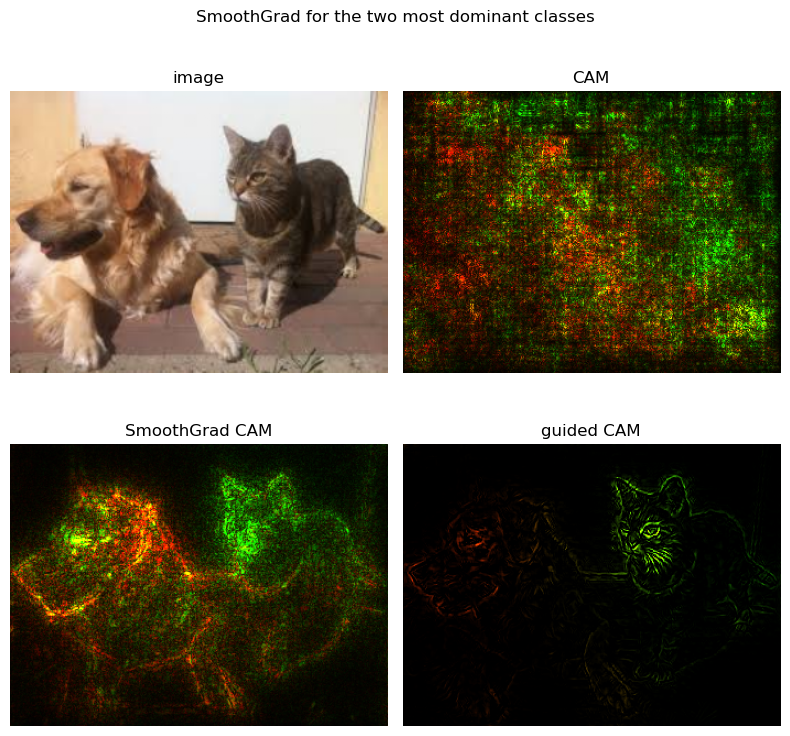

In [10]:
import sys
import subprocess

import matplotlib.pyplot as plt

subprocess.check_call([sys.executable, "-m", "pip", "install", "milankalkenings==0.1.42"])

from typing import List
import torch
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights
from torchvision.transforms import Compose, Resize, ToTensor
from milankalkenings.visualization import images_subplot


def grad_to_cam(grad: torch.Tensor) -> torch.Tensor:
    return torch.max(grad.abs(), dim=0).values


def min_max_scale(tensor: torch.Tensor) -> torch.Tensor:
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    return (tensor - min_val) / (max_val - min_val)


def calc_grad(module: torch.nn.Module, input: torch.Tensor, class_id: int) -> torch.Tensor:
    input.requires_grad_(True)
    input.grad = None  # avoid gradient accumulation
    class_probabilities = module(input)  # forward pass
    class_probabilities[0][class_id].backward()  # populate gradients
    return input.grad.data


def smooth_grad(
        module: torch.nn.Module,
        image_tensor: torch.Tensor,
        class_id: int,
        n: int,
        noise_level: float) \
        -> torch.Tensor:
    sum_grad = torch.zeros(size=image_tensor.shape)
    for _ in range(n):
        image_tensor_noisy = image_tensor + noise_level * torch.rand(size=image_tensor.shape)
        sum_grad += calc_grad(module=module, input=image_tensor_noisy, class_id=class_id)
    grad = torch.squeeze(sum_grad / n)
    return grad_to_cam(grad=torch.squeeze(grad))


def mask(tensor: torch.Tensor, thresh: float) -> torch.Tensor:
    return tensor > thresh


def greater_zero(input):
    if input is not None:
        return (input > 0).int() * input
    return None


def rectify_hook(module: torch.nn.Module, grad_inputs: torch.Tensor, grad_outputs: torch.Tensor):
    new_grad_inputs = tuple([greater_zero(gi) for gi in grad_inputs])
    return new_grad_inputs


def process_cams(cams: List[torch.Tensor], enhance: float) -> torch.Tensor:
    cams.append(torch.zeros_like(cams[-1]))
    return min_max_scale(torch.cat(cams)) * enhance



# parameters
image_path = "/kaggle/input/dog-cat/dog_cat.jpeg"
monitoring_path = ""
image_size = 256
smoothgrad_n = 50  # up to 50 is recommended by the authors
noise_level = 1
thresh = 0.3
enhance_factor = 4

# load data
to_tensor = Compose([Resize(size=image_size), ToTensor()])
image = Image.open(image_path)
image_tensor = to_tensor(image)
image_batch = torch.unsqueeze(image_tensor, dim=0)

# load models
resnet = resnet50(ResNet50_Weights.IMAGENET1K_V2).eval()
vgg = vgg16(VGG16_Weights.IMAGENET1K_V1).eval()

# determine top softmax output
top_ids = torch.topk(input=resnet(image_batch), k=2).indices[0]
print(f"top 2 class ids:", top_ids)


# CAM
# gradient of the class score w.r.t. the non-noisy input
cams = []
for class_id in top_ids:
    cam = smooth_grad(
        module=resnet,
        image_tensor=image_batch,
        n=1,
        noise_level=0,
        class_id=class_id)
    cams.append(torch.unsqueeze(cam, dim=0))
cams = process_cams(cams=cams, enhance=enhance_factor)


# SmoothGrad
# average over the gradient of the class score w.r.t. $n$ noisy versions of the input
smoothgrad_cams = []
for class_id in top_ids:
    cam = smooth_grad(
        module=resnet,
        image_tensor=image_batch,
        n=smoothgrad_n,
        noise_level=noise_level,
        class_id=class_id)
    smoothgrad_cams.append(torch.unsqueeze(cam, dim=0))
smoothgrad_cams = process_cams(cams=smoothgrad_cams, enhance=enhance_factor)

# guided CAM
# only propagate positive gradients back
for module in resnet.modules():
    module.register_backward_hook(rectify_hook)
cams_guided = []
for class_id in top_ids:
    cam = smooth_grad(
        module=resnet,
        image_tensor=image_batch,
        n=1,
        noise_level=0,
        class_id=class_id)
    cams_guided.append(torch.unsqueeze(cam, dim=0))
cams_guided = process_cams(cams=cams_guided, enhance=enhance_factor)

images_subplot(
    images=[image_tensor, cams, smoothgrad_cams, cams_guided],
    title="SmoothGrad for the two most dominant classes",
    subplot_titles=["image", "CAM", "SmoothGrad CAM", "guided CAM"],
    save_file=monitoring_path + "/benchmark")